In [1]:
import os 
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

project_name='05b-cifar10-resnet'

Bu eğiticide, CIFAR10 veri kümesinden görüntüleri sınıflandırmada% 90'ın üzerinde doğruluk elde etmek için son teknoloji bir modeli 5 dakikadan daha kısa sürede eğitmek için aşağıdaki teknikleri kullanacağız:

Data normalization

Data augmentation

Residual connections

Batch normalization

Learning rate scheduling

Weight Decay

Gradient clipping

Adam optimizer

In [2]:
data_dir = './data/cifar10'
os.listdir(data_dir + '/train')

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Torchvision'dan ImageFolder sınıfını kullanarak eğitim ve doğrulama veri setleri oluşturabiliriz. ToTensor dönüşümüne ek olarak, görüntülere başka dönüşümler de uygulayacağız. Eğitim ve doğrulama için PyTorch veri kümelerini oluştururken yapacağımız birkaç önemli değişiklik var:


    1-Doğrulama için test setini kullanın: Doğrulama için eğitim setindeki verilerin bir kısmını (ör.% 10) ayırmak yerine, test setini doğrulama setimiz olarak kullanacağız. Bu, eğitim için biraz daha fazla veri sağlar. Genel olarak, sabit bir doğrulama kümesi kullanarak en iyi model mimarisini ve hipeparametreleri seçtikten sonra, aynı modeli tüm veri kümesinde yeniden eğitmek, performansında küçük bir son artış sağlamak için iyi bir fikirdir.
    
    2-Channel-wise veri normalleştirme: Görüntü tensörlerini, ortalamayı çıkararak ve her kanaldaki standart sapmaya bölerek normalize edeceğiz. Sonuç olarak, her bir kanaldaki verilerin ortalaması 0'dır ve standart sapma 1'dir. Verilerin normalleştirilmesi, herhangi bir kanaldan alınan değerlerin eğitim sırasında orantısız şekilde kayıpları ve gradyanları etkilemesini önler; başkalarına değer veriyor.
    
    3-Rastgele veri artırmaları: Eğitim veri setinden görüntüleri yüklerken rastgele seçilen dönüşümleri uygulayacağız. Spesifik olarak, her bir görüntüyü 4 piksel dolduracağız ve ardından 32 x 32 piksel boyutunda rastgele bir kırpacağız ve ardından görüntüyü% 50 olasılıkla yatay olarak çevireceğiz. Belirli bir görüntü her yüklendiğinde dönüşüm rastgele ve dinamik olarak uygulanacağından, model her eğitim döneminde biraz farklı görüntüler görür ve bu da daha iyi bir genelleme yapmasına olanak tanır.

In [3]:
# Data transforms (normalization & data augmentation)
#Bir görüntü olduğu için, RGB'nin her renk kanalı için 3 ortalama değer ve 3 standart değer gönderiyoruz.
#stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) 3 mean 3 st


stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
traintfms = T.Compose([
    T.RandomCrop(32, padding=4, padding_mode = 'reflect'),
    T.RandomHorizontalFlip(),
    # tt.RandomRotate#random şekilde resimi döndürür
    # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), #random şekilde yeniden şekillendirip kesilmiş resimler
    # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),#parlaklık,  kontrast ,renklilik ve doygunluğun rastgelesi 
    T.ToTensor(),
    T.Normalize(*stats,inplace=True)]) 

validtfms = T.Compose([
    T.ToTensor(),
    T.Normalize(*stats)])

In [4]:
train_ds = ImageFolder(data_dir + '/train', traintfms)
valid_ds = ImageFolder(data_dir + '/test', validtfms)

In [5]:
batch_size = 256

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

Eğitim veri yükleyicisinden bazı örnek görüntülere bir göz atalım. Görüntüleri görüntülemek için, piksel değerlerini (0,1) aralığına geri getirmek için normalden kaldırmamız gerekecek.

In [6]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

def show_batch_norm(dl):
    for image, label in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(image[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

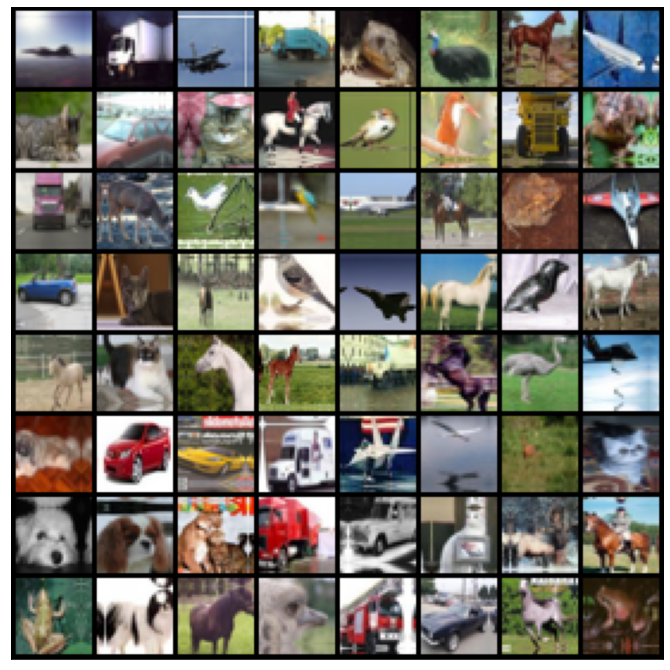

In [7]:
show_batch(train_dl)#normalize uygulanmamış resimler

In [8]:
#show_batch_norm(train_loader)#normalize uygulanmış resimler


Normalleşme nedeniyle renkler yersiz görünüyor. Çıkarım sırasında normalleştirmenin de uygulandığını unutmayın. Yakından bakarsanız, bazı görüntülerde kırpma ve yansıma dolgusunu görebilirsiniz. Yatay çevirmenin görsel incelemeden tespit edilmesi biraz zordur.

In [9]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [10]:
device = get_default_device()
device

device(type='cuda')

In [11]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Model with Residual Blocks and Batch Normalization(Artık Bloklar ve Toplu Normalleştirme ile Modelleme)


cnnn.png isimli resime bakabiliriz Resnet buna denir

In [12]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x #ReLU, giriş eklenmeden önce veya sonra uygulanabilir

In [13]:
simple_resnet = to_device(SimpleResidualBlock(), device)

In [14]:
#for img, lbl in train_dl:
#    print('input shape:',img.shape)
#    out = simple_resnet(img)
#    print('output shape:',out.shape)
#    break

In [15]:
torch.cuda.empty_cache()

Küçük görünen bu değişiklik, modelin performansında ciddi bir gelişme sağlar. Ayrıca, her convolutional layerdan sonra, önceki katmanın çıktılarını normalleştiren bir batch normalization layer ekleyeceğiz.

In [16]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
    
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        outputs = self(images)
        loss = F.cross_entropy(outputs, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        outputs = self(images)
        acc = accuracy(outputs, labels)
        loss = F.cross_entropy(outputs, labels)
        return {'val_acc':acc, 'val_loss':loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_acc':epoch_acc.item(), 'val_loss':epoch_loss.item()}
        
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}". format(epoch + 1, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [17]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [18]:
model = to_device(ResNet9(3, 10), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

## Training the model



learning rate scheduling: Sabit bir öğrenme oranı kullanmak yerine, her eğitim grubundan sonra öğrenme oranını değiştirecek bir öğrenme oranı planlayıcısı kullanacağız. Eğitim sırasında öğrenme oranını değiştirmek için birçok strateji vardır ve kullanacağımız stratejiye, düşük bir öğrenme oranıyla başlayıp kademeli olarak bunu toplu olarak yüksek bir değere yükseltmeyi içeren 'One Cycle Learning Rate Policy' adı verilir. çağların yaklaşık % 30'u için öğrenme oranı, ardından kalan çağlar için yavaş yavaş çok düşük bir değere düşürme. Daha fazla bilgi edin: (ilk %30 olarak yüksek oranda artar sonrasında yavaş yavaş düşer) https://sgugger.github.io/the-1cycle-policy.html

Weight kaybı: Ayrıca Weight kaybı işlevine ek bir terim ekleyerek Weightin çok fazla büyümesini engelleyen başka bir düzenleme tekniği olan Weight kaybını da kullanıyoruz. :https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab

Gradient clipping: layer ağırlıkları ve çıktılarının yanı sıra, büyük gradyan değerleri nedeniyle parametrelerde istenmeyen değişiklikleri önlemek için gradyanların değerlerini küçük bir aralıkla sınırlamak da yararlıdır. Bu basit ama etkili tekniğe Gradient clipping adı verilir. Daha fazla bilgi edin:

In [19]:
for img, lbl in train_dl:
    print(img.shape)
    out = model(img)
    print(out.shape)
    break

torch.Size([256, 3, 32, 32])
torch.Size([256, 10])


In [20]:
torch.cuda.empty_cache()


#### Bu değişiklikleri dahil etmek için bir fit_one_cycle işlevi tanımlayalım. Ayrıca her grup için kullanılan öğrenme oranını da kaydedeceğiz.

In [21]:
@torch.no_grad()
def evaluate(model, batch_loader):
    model.eval()
    outputs = [model.validation_step(x) for x in batch_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [22]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.11601562798023224, 'val_loss': 2.3043372631073}]

Artık modelimizi eğitmeye hazırız. SGD (stokastik gradyan iniş) yerine, daha hızlı eğitim için momentum ve uyarlanabilir öğrenme oranları gibi teknikleri kullanan Adam optimize ediciyi kullanacağız. Optimize ediciler hakkında daha fazla bilgiyi buradan edinebilirsiniz:

In [23]:
torch.cuda.empty_cache()
epochs = 15
max_lr = 0.005
grad_clip = 0.1
weight_decay = 5e-5
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [1], last_lr: 0.00076, train_loss: 1.5065, val_loss: 1.3852, val_acc: 0.5580
Epoch [2], last_lr: 0.00218, train_loss: 0.9892, val_loss: 1.0377, val_acc: 0.6576
Epoch [3], last_lr: 0.00380, train_loss: 0.8187, val_loss: 0.7594, val_acc: 0.7447
Epoch [4], last_lr: 0.00485, train_loss: 0.7233, val_loss: 1.1669, val_acc: 0.6759
Epoch [5], last_lr: 0.00497, train_loss: 0.6160, val_loss: 0.6155, val_acc: 0.7992
Epoch [6], last_lr: 0.00475, train_loss: 0.4985, val_loss: 0.8172, val_acc: 0.7523
Epoch [7], last_lr: 0.00433, train_loss: 0.4286, val_loss: 0.5450, val_acc: 0.8234
Epoch [8], last_lr: 0.00375, train_loss: 0.3638, val_loss: 0.4639, val_acc: 0.8552
Epoch [9], last_lr: 0.00306, train_loss: 0.3233, val_loss: 0.3391, val_acc: 0.8858
Epoch [10], last_lr: 0.00231, train_loss: 0.2724, val_loss: 0.3579, val_acc: 0.8875
Epoch [11], last_lr: 0.00159, train_loss: 0.2162, val_loss: 0.3014, val_acc: 0.8989
Epoch [12], last_lr: 0.00094, train_loss: 0.1686, val_loss: 0.2801, val_acc: 0.9055
E

In [ ]:
train_time = '18:44'

Modelimiz 5 dakikadan kısa bir sürede% 90'ın üzerinde doğruluk sağlayacak şekilde eğitildi! Aşağıdaki sonuçları elde etmek için veri büyütme, ağ mimarisi ve hiperparametreler ile oynamayı deneyin:

    1-)94% accuracy in under 10 minutes (easy)
    2-)90% accuracy in under 2.5 minutes (intermediate)
    3-)94% accuracy in under 5 minutes (hard)

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epochs')
    plt.ylabel('accuracies')
    plt.title('Accuracy vs. No. of epochs')
    

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
plot_losses(history)

Modelimizin henüz eğitim verilerine fazla uymadığı trendden açıkça anlaşılıyor. Aşırı uydurma üzerindeki etkilerini incelemek için toplu normalleştirme, veri artırma ve artık katmanları tek tek kaldırmayı deneyin.


In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

In [ ]:
plot_lrs(history)

Beklendiği gibi, öğrenme hızı düşük bir değerden başlar ve kademeli olarak yinelemelerin% 30'u için maksimum 0,01 değerine yükselir ve ardından kademeli olarak çok küçük bir değere düşer.

In [ ]:
def predict_image(model, img):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds = torch.max(yb, dim = 1)
    print(preds)
    return train_ds.classes[preds[0].item()]

In [ ]:
img, label = valid_ds[0]
print(img.permute(1, 2, 0).shape)#resmi göstermemiz için reshape tarzı
print(img.unsqueeze(0).shape)#4 boyuta çıkararak modelimize yollamaya yarar
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(model, img))


In [ ]:
img, lbl = valid_ds[1575]
plt.imshow(img.permute(1, 2, 0))
print('Label:', valid_ds.classes[label], ', Predicted:', predict_image(model, img))

In [ ]:
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))#sayıları 0 ile 1 arasına kırparız


In [ ]:
img, label = valid_ds[6153]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(model, img))

Modelimizin nerede kötü performans gösterdiğini belirlemek, daha fazla eğitim verisi toplayarak, modelin karmaşıklığını artırarak / azaltarak ve hipeparametreleri değiştirerek modeli geliştirmemize yardımcı olabilir.

In [ ]:
import jovian

In [ ]:
torch.save(model.state_dict(), 'cifar10-resnet9.pth')

In [ ]:
jovian.reset()
jovian.log_hyperparams(arch='resnet9', 
                       epochs=epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

In [ ]:
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'],
                   train_loss=history[-1]['train_loss'],
                   time=train_time)

In [ ]:
jovian.commit(project=project_name, environment=None, outputs=['cifar10-resnet9.pth'])
